#EEG emotion detection pipeline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
#from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

# Preprocessing EEG data

EEG data is windowed with a sliding window of 10points with a 3point overlap

In [5]:
def preprocess_data(emotion_data, emotion_):

    # remove nan values
    length=np.shape(emotion_data)[0]
    samples=[]
    for sample in range(length):
      if np.isnan(emotion_data[sample,0]):
        samples.append(int(sample))

    emotion_data_cleaned=np.delete(emotion_data, samples, 0)


    # window data to get mean values
    window_length=10
    window_overalp=3
    import math

    windows=(np.shape(emotion_data_cleaned)[0]-(window_length))//window_overalp

    #windows=math.floor(np.shape(emotion_data_cleaned)[0] / window_length)

    for window in range(windows):
      if window==0:
        #features=np.mean(emotion_data_cleaned[window*window_length:(window+1)*window_length,:], axis=0)
        features=np.mean(emotion_data_cleaned[window*window_overalp:(window*window_overalp+window_length), :], axis=0)
        test_data=features
        #print(np.shape(test_data))
      else:
        #features=np.mean(emotion_data_cleaned[window*window_length:(window+1)*window_length,:], axis=0)
        features=np.mean(emotion_data_cleaned[window*window_overalp:(window*window_overalp+window_length), :], axis=0)
        test_data=np.dstack((test_data, features))

    test_data_=np.squeeze(test_data)
    test_data=np.transpose(test_data_)
    test_data_1=np.reshape(test_data,(np.shape(test_data)[0],np.shape(test_data)[1],1)) \

    #print(f"testdata {test_data_1.shape}")
    #print("window:", windows)
    # create test labels

    #test_labels_=np.zeros((windows,3))
    test_labels_=np.zeros(windows)
    if emotion_ =='happy':
      for window in range(windows):
        test_labels_[window]=2
        #test_labels_[window,:]=[False,False,True]

    elif emotion_ =='neutral':
      for window in range(windows):
        test_labels_[window]=1
        #test_labels_[window,:]=[False,True,False]

    elif emotion_ =='sad':
      for window in range(windows):
        test_labels_[window]=0
        #test_labels_[window,:]=[True,False,False]

    #test_labels=test_labels_.astype(bool)


    return test_data_1, test_labels_

In [33]:
# Applying the preprocessing to our EEG data

all_data = []
all_data_labels=[]
#channels_to_use=[1,5,9,13,17,21]#TP9
#channels_to_use=[2,6,10,14,18,22]#AF7
#channels_to_use=[3,7,11,15,19,23]#AF8
channels_to_use=[4,8,12,16,20,24]#TP10
count=0
emotions = ["happy", "neutral", "sad"]
for subject in ['jinani','xioxuan','jion']:
    for e, emotion in enumerate(emotions):
        # Load the current file
        curr_data = pd.read_csv(f"/content/drive/MyDrive/EEG_emotions/Transfer/{emotion}_{subject}_1.csv")
        curr_data_=np.array(curr_data)[:,channels_to_use] #1:25
        test_data_1, test_labels_1 =preprocess_data(curr_data_,emotion_=emotion)
        count=count+1

        if count==1:
          all_data=test_data_1
          all_data_labels=test_labels_1
        else:
          all_data=np.vstack((all_data,test_data_1))
          all_data_labels=np.hstack((all_data_labels,test_labels_1))

# The whole dataset dimensions

In [34]:
all_data.shape, all_data_labels.shape  #((1016, 24, 1), (1016,))

((336, 6, 1), (336,))

In [35]:
## PREPARE TRAIN, VALIDATION AND TEST DATASETS

# train + (test+valid data)
X_train, X_test_, y_train, y_test_ = train_test_split(all_data, all_data_labels, train_size=0.6, random_state=48)
# test + valid data
X_valid, X_test, y_valid, y_test = train_test_split(X_test_, y_test_, train_size=0.5, random_state=48)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_valid = X_valid.astype(np.float32)

X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((201, 6, 1), (68, 6, 1), (67, 6, 1), (201,), (68,), (67,))

# TESTING WITH 5 ML MODELS

# 1. GRU model

In [25]:
# arrange data labels to bool

y_train_bool=pd.get_dummies(y_train)
y_test_bool=pd.get_dummies(y_test)
y_valid_bool=pd.get_dummies(y_valid)

# MODEL

inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()
tf.keras.utils.plot_model(model)


def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 10):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_GRU_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.keras')

        return model,history


model,history = train_model(model, X_train, y_train_bool,X_valid, y_valid_bool, save_to= '/content/drive/MyDrive/EEG_emotions/', epoch = 100)


# accuracy on a holdback test dataset
model_acc = model.evaluate(X_test, y_test_bool, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 24, 256)             │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │          18,435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,347 (849.01 KB)

 Trainable params: 217,347 (849.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3008 - loss: 1.2108
Epoch 1: val_accuracy improved from -inf to 0.29851, saving model to /content/drive/MyDrive/EEG_emotions/_best_GRU_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.3077 - loss: 1.2067 - val_accuracy: 0.2985 - val_loss: 1.1519 - learning_rate: 0.0010
Epoch 2/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4168 - loss: 1.0715
Epoch 2: val_accuracy improved from 0.29851 to 0.58209, saving model to /content/drive/MyDrive/EEG_emotions/_best_GRU_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4308 - loss: 1.0619 - val_accuracy: 0.5821 - val_loss: 0.9452 - learning_rate: 9.0484e-04
Epoch 3/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5420 - loss: 0.9730
Epoch 3: val_accuracy improved from 0.58209 to 0.70149, saving model to /content/drive/MyDrive/EEG_emotions/_best_GRU_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5446 - loss: 0.9697 - val_ac

# 2. Random Forest

In [22]:
# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(np.squeeze(X_train), y_train)

# Test accuracy the model
y_pred = clf.predict(np.squeeze(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


# 3. SVM

In [23]:
from sklearn.svm import SVC
# Train the SVM Classifier
clf = SVC(kernel="linear", probability=True, random_state=42)
clf.fit(np.squeeze(X_train), y_train)

# Validation accuracy the model
y_pred = clf.predict(np.squeeze(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9117647058823529


# 4. MLP

In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

all_data_numeric = np.array(all_data.tolist(), dtype=np.float32)
all_data_numeric = all_data_numeric.squeeze(-1)  # Remove the last dimension


# Convert data to PyTorch tensors
X = torch.tensor(all_data_numeric, dtype=torch.float32)
y = torch.tensor(all_data_labels, dtype=torch.long)

# Normalize features
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X.view(X.size(0), -1)), dtype=torch.float32)

# Split data into training and validation sets
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [37]:
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Model parameters
input_size = all_data.shape[1]
hidden_size = 128
num_classes = 3

# Initialize the model
model = MLPModel(input_size, hidden_size, num_classes)
print(model)

MLPModel(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [38]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]*100:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]*100:.2f}%")

Epoch [1/50], Train Loss: 1.0523, Train Accuracy: 46.27%, Val Loss: 1.0374, Val Accuracy: 50.00%
Epoch [2/50], Train Loss: 0.9532, Train Accuracy: 60.45%, Val Loss: 0.9761, Val Accuracy: 58.82%
Epoch [3/50], Train Loss: 0.8654, Train Accuracy: 64.55%, Val Loss: 0.9231, Val Accuracy: 64.71%
Epoch [4/50], Train Loss: 0.7700, Train Accuracy: 70.52%, Val Loss: 0.8718, Val Accuracy: 66.18%
Epoch [5/50], Train Loss: 0.7105, Train Accuracy: 72.01%, Val Loss: 0.8229, Val Accuracy: 69.12%
Epoch [6/50], Train Loss: 0.6570, Train Accuracy: 75.75%, Val Loss: 0.7720, Val Accuracy: 69.12%
Epoch [7/50], Train Loss: 0.6009, Train Accuracy: 77.99%, Val Loss: 0.7203, Val Accuracy: 72.06%
Epoch [8/50], Train Loss: 0.5516, Train Accuracy: 80.22%, Val Loss: 0.6764, Val Accuracy: 72.06%
Epoch [9/50], Train Loss: 0.5176, Train Accuracy: 83.21%, Val Loss: 0.6411, Val Accuracy: 73.53%
Epoch [10/50], Train Loss: 0.4859, Train Accuracy: 81.34%, Val Loss: 0.6117, Val Accuracy: 73.53%
Epoch [11/50], Train Loss: 0.

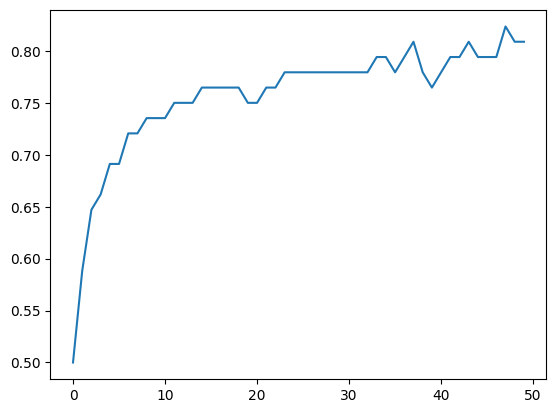

In [39]:
plt.plot(val_accuracies)

# 5. CFNN
Discard because it doesn't work with all features and it wont be compatible (?)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from itertools import product
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR



class FuzzyInferenceBlock(nn.Module):
    def __init__(self, output_dim, i_fmap, mu, sigma):
        super(FuzzyInferenceBlock, self).__init__()
        self.output_dim = output_dim
        self.index = i_fmap
        self.mu_map = fRules_sigma * mu  # `fRules_sigma` should be defined globally
        self.sigma_map = torch.ones((self.mu_map.size(0), output_dim)) * sigma  # Match `mu_map` size

    def forward(self, inputs):
        # Ensure `inputs` slicing is within bounds
        n_features = self.mu_map.size(0)
        start_idx = self.index * n_features
        end_idx = start_idx + n_features
        fMap = inputs[:, start_idx:end_idx]  # Slice inputs correctly

        # Align dimensions for broadcasting
        aligned_x = fMap.unsqueeze(-1).expand(-1, -1, self.output_dim)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map

        # Calculate output of each neuron (fuzzy rule)
        phi = torch.exp(-torch.sum((aligned_x - aligned_c) ** 2 / (2 * aligned_s ** 2), dim=1))
        return phi

class FCNN(nn.Module):
    def __init__(self, n_femap=4, mu=3.0, sigma=1.2, dropout=True, num_classes=3):
        super(FCNN, self).__init__()
        # Reduced convolutional layers to fit input size constraints
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(20, n_femap, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.2) if dropout else nn.Identity()

        # Fuzzy inference layers
        self.fuzzy_layers = nn.ModuleList(
            [FuzzyInferenceBlock(output_dim=n_neurons, i_fmap=i, mu=mu, sigma=sigma) for i in range(n_femap)]
        )
        self.fc = nn.Linear(n_neurons * n_femap, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.dropout(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fuzzy inference

        # Fuzzy inference processing
        fuzzy_outs = [layer(x) for layer in self.fuzzy_layers]
        merged = torch.cat(fuzzy_outs, dim=1)
        out = self.fc(merged)
        return out

In [ ]:
# Define fuzzy rules and sampling based on given n_features and n_neurons
n_features = 24  # Number of features in each EEG sample
n_neurons = 60  # Number of fuzzy rules, it has to be <= 3**n_features
fRules = list(product([-1.0, 0.0, 1.0], repeat=n_features))
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = torch.tensor(out_fRules).transpose(0, 1).float()

In [ ]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(np.squeeze(X_train), dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

X_tensor = torch.tensor(np.squeeze(X_test), dtype=torch.float32)
y_tensor = torch.tensor(y_test, dtype=torch.long)
val_dataset = TensorDataset(X_tensor, y_tensor)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [ ]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Initialize the model with the optimal parameters
model = FCNN(n_femap=3, mu=1.0, sigma=2.0, dropout=False, num_classes=3)  # Optimal 'mu', 'sigma', 'dropout'
criterion = nn.CrossEntropyLoss()

# Define optimizer and learning rate scheduler with optimal parameters
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimal learning rate
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Optimal 'step_size' and 'gamma'

# Training loop with validation and learning rate scheduler
num_epochs = 200
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add a channel dimension: [batch_size, 1, n_features]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(1)  # Ensure the inputs match model input dimensions
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step()

print("Training complete.")

# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# TEST SUBJECT GENERALIZATION

In [10]:
# preprocess the new recorded data

## train data on 'jinani','xioxuan'
all__train_data = []
all__train_data_labels=[]
count=0
emotions = ["happy", "neutral", "sad"]
for subject in ['jinani','jion']:
    for e, emotion in enumerate(emotions):
        # Load the current file
        curr_data = pd.read_csv(f"/content/drive/MyDrive/EEG_emotions/Transfer/{emotion}_{subject}_1.csv")
        curr_data_=np.array(curr_data)[:,1:25]
        test_data_1, test_labels_1 =preprocess_data(curr_data_,emotion_=emotion)
        count=count+1

        if count==1:
          all__train_data=test_data_1
          all__train_data_labels=test_labels_1
        else:
          all__train_data=np.vstack((all__train_data,test_data_1))
          all__train_data_labels=np.hstack((all__train_data_labels,test_labels_1))
          print(all__train_data.shape)


## test data on 'jion'
all__test_data = []
all__test_data_labels=[]
count=0
emotions = ["happy", "neutral", "sad"]
for subject in ['xioxuan']:
    for e, emotion in enumerate(emotions):
        # Load the current file
        curr_data = pd.read_csv(f"/content/drive/MyDrive/EEG_emotions/Transfer/{emotion}_{subject}_1.csv")
        curr_data_=np.array(curr_data)[:,1:25]
        test_data_1, test_labels_1 =preprocess_data(curr_data_,emotion_=emotion)
        count=count+1

        if count==1:
          all__test_data=test_data_1
          all__test_data_labels=test_labels_1
        else:
          all__test_data=np.vstack((all__test_data,test_data_1))
          all__test_data_labels=np.hstack((all__test_data_labels,test_labels_1))


(74, 24, 1)
(116, 24, 1)
(153, 24, 1)
(189, 24, 1)
(226, 24, 1)


# Random Forest

In [11]:
# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(np.squeeze(all__train_data), all__train_data_labels)

# Test accuracy the model
y_pred = clf.predict(np.squeeze(all__test_data))
accuracy = accuracy_score(all__test_data_labels, y_pred)
print(accuracy)

0.6363636363636364


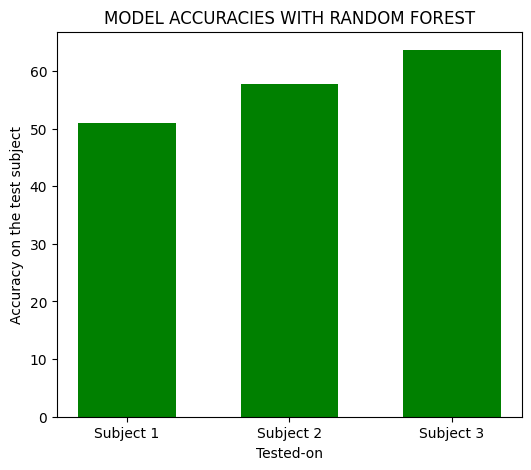

In [12]:
# Generalization accuracies

test_on=['jion', 'jinani','xiouxan']
acc=[50.9, 57.75,63.63]

models=['Subject 1', 'Subject 2', 'Subject 3']

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6, 5))

plt.bar(models, acc, color ='green',
        width = 0.6)

plt.xlabel("Tested-on")
plt.ylabel("Accuracy on the test subject")
plt.title("MODEL ACCURACIES WITH RANDOM FOREST")
plt.show()

# GRU

In [37]:
# MODEL

inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()
tf.keras.utils.plot_model(model)


def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 10):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_GRU_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.keras')

        return model,history


model,history = train_model(model, X_train, y_train,X_test, y_test, save_to= '/content/drive/MyDrive/EEG_emotions/', epoch = 100)


# accuracy on a holdback test dataset
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 24, 256)             │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │          18,435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,347 (849.01 KB)

 Trainable params: 217,347 (849.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4360 - loss: 1.0858
Epoch 1: val_accuracy improved from -inf to 0.69578, saving model to /content/drive/MyDrive/EEG_emotions/_best_GRU_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.4388 - loss: 1.0815 - val_accuracy: 0.6958 - val_loss: 0.8380 - learning_rate: 0.0010
Epoch 2/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6290 - loss: 0.7856
Epoch 2: val_accuracy did not improve from 0.69578
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6322 - loss: 0.7792 - val_accuracy: 0.6506 - val_loss: 0.6357 - learning_rate: 9.0484e-04
Epoch 3/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7775 - loss: 0.5150
Epoch 3: val_accuracy did not improve from 0.69578
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7832 - loss: 0.5073 - val_accuracy: 0.6747 - val_loss: 0.7113 - learning_rate: 8.1873e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9351 - loss: 0.187

# Create figures

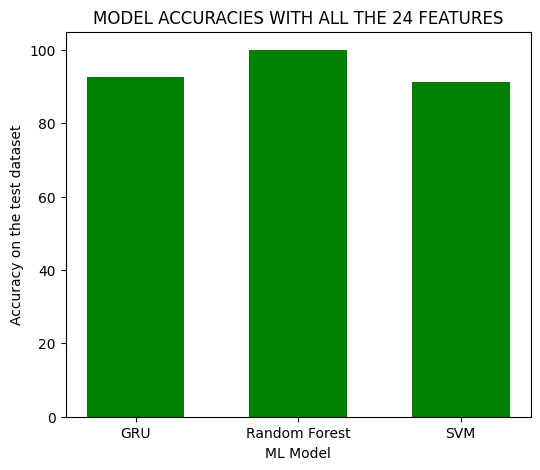

In [59]:
# Accuracies

acc=[92.647, 100, 91.176]
models=['GRU', 'Random Forest', 'SVM']

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6, 5))

plt.bar(models, acc, color ='green',
        width = 0.6)

plt.xlabel("ML Model")
plt.ylabel("Accuracy on the test dataset")
plt.title("MODEL ACCURACIES WITH ALL THE 24 FEATURES")
plt.show()